In [18]:
# MISC
import os
import sys
sys.path.append("..")

os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

from rich.pretty import pprint
import shutup
shutup.please()

import numpy as np

# RL 
import jax
import jax.numpy as jnp
import gymnasium
import ogbench
import ogbench.online_locomotion.wrappers
import flax.linen as nn

# Custom
from envs.ogbench.ant_utils import MazeVizWrapper, plot_value
from utils.datasets import Dataset, GCDataset
from agents.fb import get_config, ForwardBackwardAgent

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

# Use either exising dataset or create from data_gen_scripts
# 'pointmaze-medium-explore-v0'
# env = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
#     "pointmaze-medium-explore-v0",
#     env_only=True, render_mode='rgb_array'
# )
env, train_dataset, valid_dataset = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
    "pointmaze-medium-stitch-v0",
    env_only=False
)
obs, info = env.reset()
# env = MazeVizWrapper(env)
# train_dataset = Dataset.create(**train_dataset)
# #pointmaze_explore_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/pointmaze-medium-explore-v0.npz")
# fig, ax = plt.subplots()

# polygons = env.draw(ax=ax)

# #ax.scatter(pointmaze_explore_data['observations'][:, 0], pointmaze_explore_data['observations'][:, 1])
# ax.scatter(train_dataset['observations'][:, 0], train_dataset['observations'][:, 1])

In [24]:
x_min, x_max = train_dataset['observations'][:, 0].min(), train_dataset['observations'][:, 0].max()
y_min, y_max = train_dataset['observations'][:, 1].min(), train_dataset['observations'][:, 1].max()
normalized_observations = np.zeros_like(train_dataset['observations'])
normalized_observations[:, 0] = (train_dataset['observations'][:, 0] - x_min) / (x_max - x_min)  # Normalize x
normalized_observations[:, 1] = (train_dataset['observations'][:, 1] - y_min) / (y_max - y_min)  # Normalize y

In [26]:
train_dataset['observations'] = normalized_observations

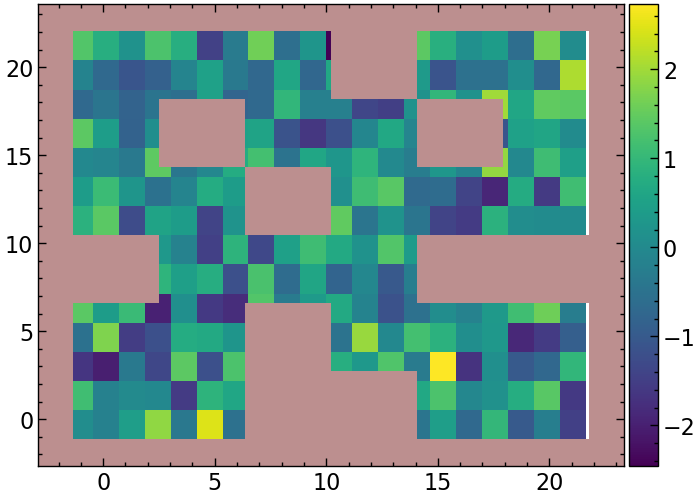

In [3]:
fig, ax = plt.subplots()
ax.scatter(*info['goal'], c='red')
plot_value(env, train_dataset, value_fn=lambda x: np.random.normal(size=x.shape[0]), fig=fig, ax=ax)

In [9]:
import flax.linen as nn
from typing import *
from utils.networks import FValue

def orthogonal_init(scale=1.0):
    return nn.initializers.orthogonal(scale)

def variance_scaling(scale=0.5):
    """Default kernel initializer."""
    return nn.initializers.variance_scaling(scale, 'fan_avg', 'uniform')

class MLP(nn.Module):
    """Multi-layer perceptron.

    Attributes:
        hidden_dims: Hidden layer dimensions.
        activations: Activation function.
        activate_final: Whether to apply activation to the final layer.
        kernel_init: Kernel initializer.
        layer_norm: Whether to apply layer normalization.
    """

    hidden_dims: Sequence[int] = (256, 256, 256)
    activations: Any = nn.relu
    activate_final: bool = False
    kernel_init: Any = variance_scaling()
    layer_norm: bool = False
    layer_norm_only_first: bool = True # used with tanh
    
    @nn.compact
    def __call__(self, x):
        for i, size in enumerate(self.hidden_dims):
            x = nn.Dense(size, kernel_init=self.kernel_init)(x)
            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.layer_norm_only_first and i == 0:
                    x = nn.LayerNorm()(x)
                    x = nn.tanh(x)
                if self.layer_norm:
                    x = nn.LayerNorm()(x)
                if i != 0 or not self.layer_norm_only_first:
                    x = self.activations(x)
        return x

def project_z(z):
    return z * jnp.sqrt(z.shape[-1]) / jnp.linalg.norm(z, axis=-1, keepdims=True)

def sample_z(batch_size, latent_dim, key):
    z = jax.random.normal(shape=(batch_size, latent_dim), key=key)
    return project_z(z)

latent_z = sample_z(256, 20, GLOBAL_KEY)
test_ff = FValue(latent_z_dim=20)
ff_params = test_ff.init(GLOBAL_KEY, train_dataset['observations'][0], train_dataset['actions'][0], latent_z[0])
test_ff.apply(ff_params, train_dataset['observations'][:256], train_dataset['actions'][:256], latent_z[:256])[0].max()

Array(0.13544463, dtype=float32)

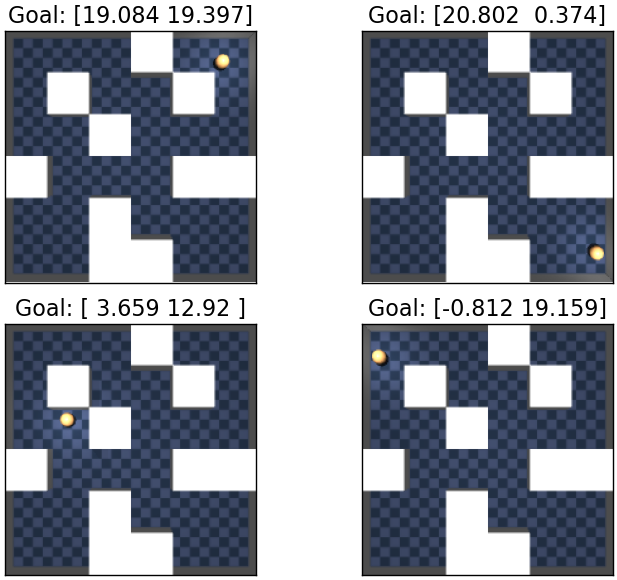

In [2]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()
for idx, task_id in enumerate([1, 2, 3, 4]):
    ob, info = env.reset(
        options=dict(
            task_id=task_id,
            render_goal=True,
        )
    )
    goal = info['goal']
    goal_rendered = info['goal_rendered']
    axs[idx].imshow(goal_rendered)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title(f"Goal: {np.round(goal, 3)}")
plt.tight_layout()